# Download Dataset

In [ ]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip

--2022-06-21 12:07:39--  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.169.13
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.169.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 327699796 (313M) [application/zip]
Saving to: ‘data_semantics.zip’

data_semantics.zip  100%[===================>] 312.52M  27.7MB/s    in 12s     

2022-06-21 12:07:52 (25.8 MB/s) - ‘data_semantics.zip’ saved [327699796/327699796]



In [ ]:
!unzip data_semantics.zip

Archive:  data_semantics.zip
   creating: testing/
   creating: testing/image_2/
  inflating: testing/image_2/000000_10.png  
  inflating: testing/image_2/000001_10.png  
  inflating: testing/image_2/000002_10.png  
  inflating: testing/image_2/000003_10.png  
  inflating: testing/image_2/000004_10.png  
  inflating: testing/image_2/000005_10.png  
  inflating: testing/image_2/000006_10.png  
  inflating: testing/image_2/000007_10.png  
  inflating: testing/image_2/000008_10.png  
  inflating: testing/image_2/000009_10.png  
  inflating: testing/image_2/000010_10.png  
  inflating: testing/image_2/000011_10.png  
  inflating: testing/image_2/000012_10.png  
  inflating: testing/image_2/000013_10.png  
  inflating: testing/image_2/000014_10.png  
  inflating: testing/image_2/000015_10.png  
  inflating: testing/image_2/000016_10.png  
  inflating: testing/image_2/000017_10.png  
  inflating: testing/image_2/000018_10.png  
  inflating: testing/image_2/000019_10.png  
  inflating: testin

# Load Necessary Library

In [ ]:
import numpy as np
import pandas as pd
import os 
import math
import random

from glob import glob
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape, BatchNormalization, Dropout, Activation, MaxPool2D, concatenate
from keras.models import Model
from PIL import Image

# Visualization Sample Data

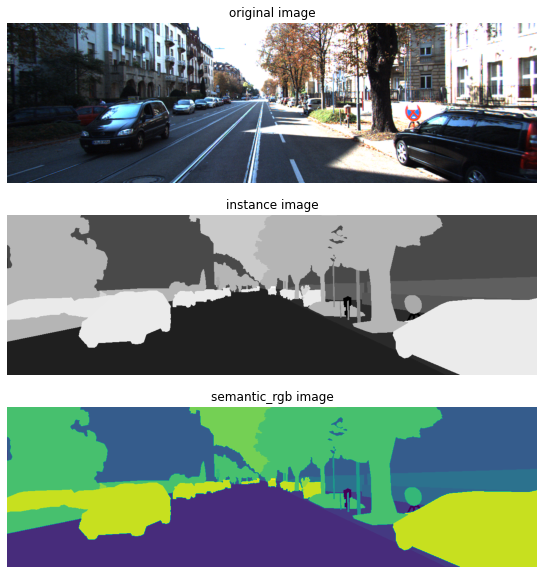

In [ ]:
image = Image.open('/content/training/image_2/000000_10.png')
instance = Image.open('/content/training/instance/000000_10.png')
semantic = Image.open('/content/training/semantic/000000_10.png')

image = np.array(image)
instance = np.array(instance)
semantic = np.array(semantic)

plt.figure(figsize=(20, 10))
plt.subplot(311)
plt.imshow(image)
plt.title('original image')
plt.axis('off')

plt.subplot(312)
plt.imshow(instance, 'gray')
plt.title('instance image')
plt.axis('off')

plt.subplot(313)
plt.imshow(semantic)
plt.title('semantic_rgb image')
plt.axis('off')
plt.show()

# Set Data Loader

In [ ]:
batch_size = 10
epochs = 50
lr = 1e-2

In [ ]:
image_dir = '/content/training/image_2/'
trg_image_dir = '/content/training/semantic/'

image_files = glob(image_dir + '*.png')
trg_image_files = glob(trg_image_dir + '*.png')

In [ ]:
images = []
trg_images = []

for image_file, trg_image_file in zip(image_files, trg_image_files):
    image = Image.open(image_file)
    image_mode = image.mode
    image = tf.image.resize(np.array(image), (224, 224))
    images.append(image)

    trg_image = Image.open(trg_image_file)
    trg_image = np.expand_dims(np.array(trg_image), -1)
    trg_image = (trg_image == 7).astype(np.uint8) * 1 
    trg_image = tf.image.resize(trg_image, (224, 224))
    trg_images.append(trg_image)

images = np.array(images) / 255.
trg_images = np.array(trg_images) 

print(len(images), len(trg_images))

200 200


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((images, trg_images))
train_loader = train_dataset.batch(batch_size=batch_size).shuffle(1024)

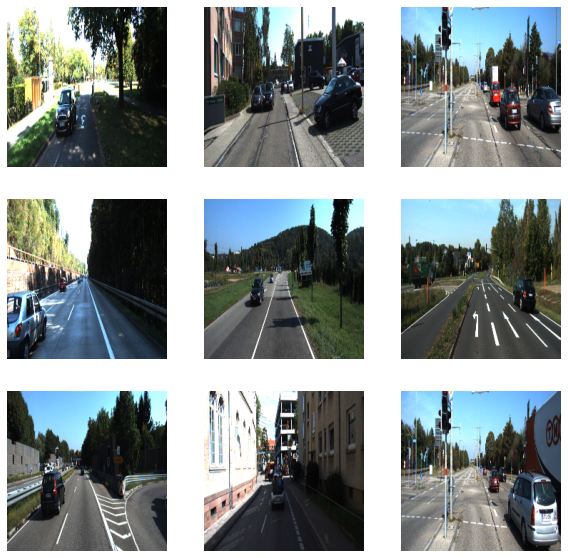

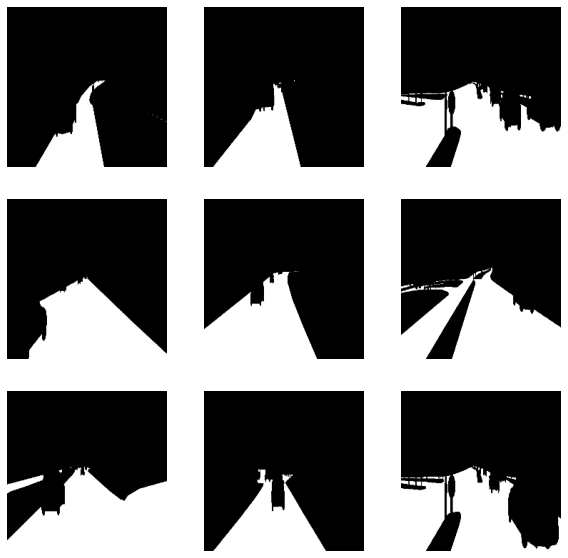

In [ ]:
sample = next(iter(train_loader))
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(sample[0][i])
    plt.axis('off')
plt.show()

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(tf.reshape(sample[1][i], (224, 224)), 'gray')
    plt.axis('off')
plt.show()

# Define UNet 

In [ ]:
def conv2d_block(x, channel):
    x = Conv2D(channel, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(channel, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def unet():
    inputs = Input((224, 224, 3))
    
    c1 = conv2d_block(inputs, 64)
    p1 = MaxPool2D((2,2))(c1)
    p1 = Dropout(0.5)(p1)
    
    c2 = conv2d_block(p1, 128)
    p2 = MaxPool2D((2,2))(c2)
    p2 = Dropout(0.5)(p2)
    
    c3 = conv2d_block(p2, 256)
    p3 = MaxPool2D((2,2))(c3)
    p3 = Dropout(0.5)(p3)

    c4 = conv2d_block(p3, 512)
    p4 = MaxPool2D((2,2))(c4)
    p4 = Dropout(0.5)(p4)

    c5 = conv2d_block(p4, 1024)
    
    u6 = Conv2DTranspose(512, 2, 2, output_padding=(0, 0))(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.5)(u6)
    c6 = conv2d_block(u6, 512)
    
    u7 = Conv2DTranspose(256, 2, 2, output_padding=(0, 0))(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.5)(u7)
    c7 = conv2d_block(u7, 256)
    
    u8 = Conv2DTranspose(128, 2, 2, output_padding=(0, 0))(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.5)(u8)
    c8 = conv2d_block(u8, 128)
    
    u9 = Conv2DTranspose(64, 2, 2, output_padding=(0, 0))(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.5)(u9)
    c9 = conv2d_block(u9, 64)
    
    outputs = Conv2D(1, 1, activation='sigmoid')(c9)
    model = Model(inputs, outputs)
    return model

# Define IOU

In [ ]:
def iou(targets, preds):
    smooth = 1e-5

    preds = tf.reshape(preds, [-1])
    targets = tf.reshape(targets, [-1])

    intersection = tf.reduce_sum(preds * targets)
    union = tf.reduce_sum(preds) + tf.reduce_sum(targets) - intersection
    iou_score = (intersection + smooth) / (union + smooth)
    return iou_score

# Set Model


In [ ]:
model = unet()
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
    loss=tf.losses.binary_crossentropy, 
    metrics=[iou]
)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 224, 224, 64  256        ['conv2d_19[0][0]']              
 ormalization)                  )                                                           

# Training

In [ ]:
hist = model.fit(
    train_loader,
    epochs=epochs
)

Epoch 1/50
20/20 [==============================] - 23s 246ms/step - loss: 0.4688 - iou: 0.2646
Epoch 2/50
20/20 [==============================] - 5s 245ms/step - loss: 0.2804 - iou: 0.4481
Epoch 3/50
20/20 [==============================] - 5s 247ms/step - loss: 0.2204 - iou: 0.5601
Epoch 4/50
20/20 [==============================] - 5s 246ms/step - loss: 0.2153 - iou: 0.5857
Epoch 5/50
20/20 [==============================] - 5s 246ms/step - loss: 0.2189 - iou: 0.5504
Epoch 6/50
20/20 [==============================] - 5s 246ms/step - loss: 0.2013 - iou: 0.6011
Epoch 7/50
20/20 [==============================] - 5s 245ms/step - loss: 0.1918 - iou: 0.6036
Epoch 8/50
20/20 [==============================] - 5s 245ms/step - loss: 0.1886 - iou: 0.6247
Epoch 9/50
20/20 [==============================] - 5s 245ms/step - loss: 0.1816 - iou: 0.6262
Epoch 10/50
20/20 [==============================] - 5s 245ms/step - loss: 0.1701 - iou: 0.6391
Epoch 11/50
20/20 [=============================

# Visualization Loss & Iou

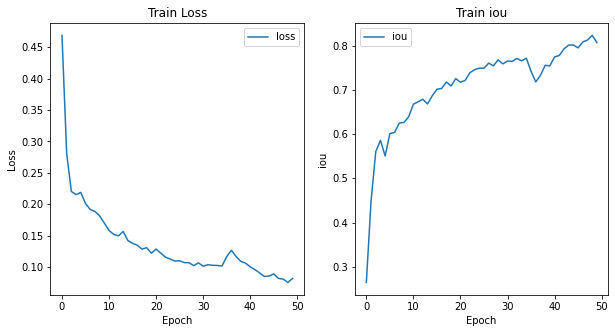

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(hist.history['loss'], label='loss')
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.subplot(122)
plt.plot(hist.history['iou'], label='iou')
plt.legend(loc='best')
plt.title('Train iou')
plt.xlabel('Epoch')
plt.ylabel('iou')
plt.show()

# Test Model

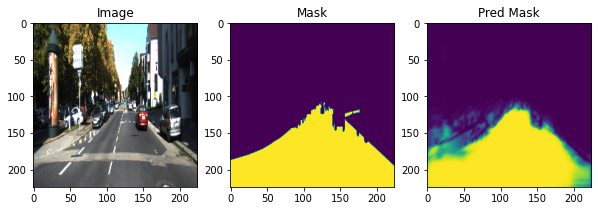

Iou:  0.86624366


In [ ]:
img , trg_img = next(iter(train_loader))
img, trg_img = img[0:1], trg_img[0]

plt.figure(figsize=(10, 10))
plt.subplot(131)
plt.imshow(img[0])
plt.title('Image')
plt.subplot(132)
trg_img = np.reshape(trg_img, (224, 224))
plt.imshow(trg_img)
plt.title('Mask')

pred = model.predict(img)
pred = np.reshape(pred, (224, 224))
plt.subplot(133)
plt.imshow(pred)
plt.title('Pred Mask')
plt.show()

print('Iou: ', iou(pred, trg_img).numpy())